# Variational Quantum Eigensolver (VQE)

Original implementation and further explanations can be found [here](https://github.com/DavitKhach/quantum-algorithms-tutorials/blob/master/variational_quantum_eigensolver.ipynb
).

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, BasicAer, execute
from qiskit.algorithms.optimizers import SPSA 
from qiskit.circuit import Parameter
from qiskit.circuit.library.standard_gates import UGate
from qiskit.opflow import PauliOp, I, X, Y, Z
from qiskit.algorithms import NumPyEigensolver

The ground state energy is an important property of a physical system. Most applications are found in chemistry e.g. for calculating the ground state of molecules. However, this can be generalised to any optimization problem with the objective to find the eigenvector with the smallest eigenvalues of a so called hamiltonian $\mathrm{H}$.

As you might know, finding eigenvectors is a non-trivial problem which is why e.g. in chemistry, finding the ground state energy of certain molecules can be computationally very expensive.

You can think of the hamiltonian as a more educated variant of the loss function as we've seen before in PQCs, or in classical optimization problems.

To start with an example, let's consider a very simple hamiltonian using only $1$ qubit and $4$ weighted Pauli operators:

$$\mathrm{\hat{H}} = a \cdot I + b \cdot Z + c \cdot X + d \cdot Y,$$

where $a$, $b$ and $c$ are real valued coefficients and the Pauli operators $I$, $Z$, $X$, and $Y$ are defined as follows:

$$
I = \begin{pmatrix}
1 & 0\\
0 & 1
\end{pmatrix},
\qquad
Z = \begin{pmatrix}
1 & 0\\
0 & -1
\end{pmatrix},
\qquad
X = \begin{pmatrix}
0 & 1\\
1 & 0
\end{pmatrix},
\qquad
Y = \begin{pmatrix}
0 & -i\\
i & 0
\end{pmatrix}.
$$

We can create such a hamiltonian using qiskits [Operator Flow](https://qiskit.org/documentation/tutorials/operators/01_operator_flow.html) API:

In [2]:
def hamiltonian_operator(a, b, c, d):
    """
    Creates a*I + b*Z + c*X + d*Y pauli sum 
    that will be our Hamiltonian operator.
    
    """
    return a*I + b*Z + c*X + d*Y

We can verify that this hamiltonian fits the form defined above:

In [3]:
rng = np.random.default_rng(12345)

scale = 10
a, b, c, d = (scale*rng.random(), scale*rng.random(), 
              scale*rng.random(), scale*rng.random())
H = hamiltonian_operator(a, b, c, d)
print(H)

2.2733602246716966 * I
+ 3.1675833970975287 * Z
+ 7.973654573327341 * X
+ 6.762546707509745 * Y


After we defined the hamiltonian, we want to find the lowest eigenvalue a.k.a. ground state. For a given eigenvector $\vert \psi \rangle$ we can measure the expectation value of the hamiltonian as

$$\left\langle \mathrm{\hat{H}} \right\rangle = \left\langle \psi \right| \mathrm{\hat H} \left| \psi \right\rangle = a \cdot \left\langle \psi \right| \hat I \left| \psi \right\rangle + b \cdot \left\langle \psi \right| \hat Z \left| \psi \right\rangle + c \cdot \left\langle \psi \right| \hat X \left| \psi \right\rangle + d \cdot \left\langle \psi \right| \hat Y \left| \psi \right\rangle$$

which gives us the eigenvalue.

Using classical algorithms such as [qiskits NumPyEigensolver](https://qiskit.org/documentation/stable/0.28/stubs/qiskit.algorithms.NumPyEigensolver.html) we can obtain a reference value which we can later use to test the value obtained from our VQE.

In [4]:
es = NumPyEigensolver(2) #k=1 eigenvalues
exact_result = es.compute_eigenvalues(H)
reference_energy = min(np.real(exact_result.eigenvalues))
print('The exact ground state energy is: {}'.format(reference_energy))

The exact ground state energy is: -8.65114387407635


This approach works analytically. In case of the VQE we need to cover all possible wavefunctions $\vert \psi \rangle$ that could minimize the hamiltonians expectation value.
In the $1$-qubit case this is equivalent of being able to reach every point on the Bloch Sphere's surface using the parameters in our variational circuit.
As only two parameters allow us to describe a general qubit state as
$$
\left| \psi \right\rangle = \begin{pmatrix}
\cos{\left( \theta/2 \right)}\\
e^{i \varphi} \cdot \sin{\left( \theta/2 \right)}
\end{pmatrix},
$$

we only need two rotational gates in our circuit:

$$
R_x(t_1) = \begin{pmatrix}
cos(\frac{t_1}{2}) & -i \cdot sin(\frac{t_1}{2})\\
-i \cdot sin(\frac{t_1}{2}) & cos(\frac{t_1}{2})
\end{pmatrix},
\qquad
R_y(t_2) = \begin{pmatrix}
cos(\frac{t_2}{2}) & -sin(\frac{t_2}{2})\\
sin(\frac{t_2}{2}) & cos(\frac{t_2}{2})
\end{pmatrix}.
$$

A proper circuit can be created using the following code:

In [5]:
def quantum_state_preparation(circuit, parameters):
    q = circuit.qregs[0] # q is the quantum register where the info about qubits is stored
    circuit.rx(parameters[0], q[0]) # q[0] is our one and only qubit XD
    circuit.ry(parameters[1], q[0])
    return circuit

q = QuantumRegister(1)
circuit = QuantumCircuit(q)

# quantum state preparation
circuit = quantum_state_preparation(circuit, [Parameter('t1'), Parameter('t2')])
circuit.draw()

┌────────┐┌────────┐
q0: ┤ Rx(t1) ├┤ Ry(t2) ├
    └────────┘└────────┘

You might have noticed that the circuit is still lacking measurements. This is because our hamiltonian has different pauli operators, for which we need to find a corresponding measurement.
In case of the identity, we obtain the expectation value $\langle \mathrm{\hat H} \rangle$ to $a \cdot \left\langle \psi \right| I \left| \psi \right\rangle = a$.

To measure the hamiltonian in the $z$, $x$ and $y$ basis respectively, it's important to recall that any quantum state can be represented in those basis.

As you might already noticed, we can only take measurements in the $z$ basis using Qiskit. Therefore we need to rotate our state accordingly in case of the $x$ and $y$ basis measurements.

In [6]:
H_gate = UGate(np.pi/2, 0, np.pi).to_matrix()
print("H_gate:")
print((H_gate * np.sqrt(2)).round(5))

Y_gate = UGate(np.pi/2, 0, np.pi/2).to_matrix()
print("Y_gate:")
print((Y_gate * np.sqrt(2)).round(5))

H_gate:
[[ 1.+0.j  1.-0.j]
 [ 1.+0.j -1.+0.j]]
Y_gate:
[[ 1.+0.j -0.-1.j]
 [ 1.+0.j  0.+1.j]]


Using the circuit generator defined above, we now just add the case decisions for each type of measurement resulting in the overall definition of our VQE circuit:

In [7]:
def vqe_circuit(parameters, measure):
    """
    Creates a device ansatz circuit for optimization.
    :param parameters_array: list of parameters for constructing ansatz state that should be optimized.
    :param measure: measurement type. E.g. 'Z' stands for Z measurement.
    :return: quantum circuit.
    """
    q = QuantumRegister(1)
    c = ClassicalRegister(1)
    circuit = QuantumCircuit(q, c)

    # quantum state preparation
    circuit = quantum_state_preparation(circuit, parameters)

    # measurement
    if measure == 'Z':
        circuit.measure(q[0], c[0])
    elif measure == 'X':
        circuit.u(np.pi/2, 0, np.pi, q[0]) # rotation around 
        circuit.measure(q[0], c[0])
    elif measure == 'Y':
        circuit.u(np.pi/2, 0, np.pi/2, q[0])
        circuit.measure(q[0], c[0])
    else:
        raise ValueError('Not valid input for measurement: input should be "X" or "Y" or "Z"')

    return circuit

Last but not least, we define a `quantum_module` that generates the VQE circuit, runs the simulation, and returns the expectation value.

In [8]:
def quantum_module(parameters, measure):
    # measure
    if measure == 'I':
        return 1
    elif measure == 'Z':
        circuit = vqe_circuit(parameters, 'Z')
    elif measure == 'X':
        circuit = vqe_circuit(parameters, 'X')
    elif measure == 'Y':
        circuit = vqe_circuit(parameters, 'Y')
    else:
        raise ValueError('Not valid input for measurement: input should be "I" or "X" or "Z" or "Y"')
    
    shots = 8192
    backend = BasicAer.get_backend('qasm_simulator')
    job = execute(circuit, backend, shots=shots)
    result = job.result()
    counts = result.get_counts()
    
    # expectation value estimation from counts
    expectation_value = 0
    for measure_result in counts:
        sign = +1
        if measure_result == '1':
            sign = -1
        expectation_value += sign * counts[measure_result] / shots
        
    return expectation_value

For convenience we introduce a helper function that creates a pauli dictionary from Qiskits PauliOp object where the coefficients are stored and can be accessed using the Pauli operator as key.

In [9]:
def pauli_operator_to_dict(pauli_operator):
    """
    from WeightedPauliOperator return a dict:
    {I: a, X: b, Z: c, Y: d}.
    :param pauli_operator: qiskit's PauliOp
    :return: a dict in the desired form.
    """
    paulis_dict = {}
    #print(pauli_operator)
    for x in pauli_operator:
        label = str(x.primitive.paulis[0])
        paulis_dict[label] = np.real(x.coeffs[0]) #real part of the coefficient

    return paulis_dict
pauli_dict = pauli_operator_to_dict(H)

To aggregate all the expectation values we introduce one final method that calls the VQE circuit for each of our Pauli operators using the current parameters, weights the resulting expecation values accordingly, and sums everything to a final value representing the ground state.

In [10]:
def vqe(parameters):
        
    # quantum_modules
    quantum_module_I = pauli_dict['I'] * quantum_module(parameters, 'I')
    quantum_module_Z = pauli_dict['Z'] * quantum_module(parameters, 'Z')
    quantum_module_X = pauli_dict['X'] * quantum_module(parameters, 'X')
    quantum_module_Y = pauli_dict['Y'] * quantum_module(parameters, 'Y')
    
    # summing the measurement results
    classical_adder = quantum_module_I + quantum_module_Z + quantum_module_X + quantum_module_Y
    
    return classical_adder

This method is then called from the optimization routine, here `sklearn.optimize`, iteratively.

The exact ground state energy is: -8.65114387407635
The estimated ground state energy from VQE algorithm is: -8.640252795842816


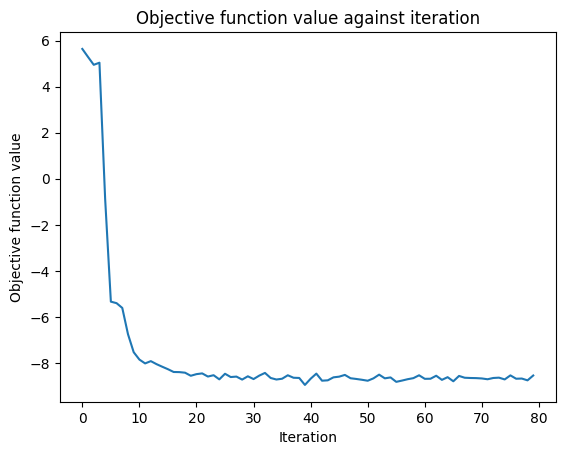

In [11]:
parameters_array = np.array([np.pi, np.pi])
tol = 1e-3 # tolerance for optimization precision.

loss = []
def callback(n_t, params_t, fun_t, *args, **kwargs):
    loss.append(fun_t)

#vqe_result = minimize(vqe, parameters_array, method="Powell", tol=tol)
spsa = SPSA(maxiter=80, callback=callback)
vqe_result = spsa.minimize(fun=vqe, x0=parameters_array)

print('The exact ground state energy is: {}'.format(reference_energy))
print('The estimated ground state energy from VQE algorithm is: {}'.format(vqe_result.fun))


plt.title("Objective function value against iteration")
plt.xlabel("Iteration")
plt.ylabel("Objective function value")
plt.plot(loss)
plt.show()